# **Analysis of decoding results**

## **Libraries**

In [1]:
#%pip install pandas matplotlib seaborn nltk sacrebleu

In [2]:
import os
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import nltk
import sacrebleu

from utils import constants

## **Directories**

In [3]:
RESULTS_FOLDER = constants.RESULTS_DATA_FOLDER
DECODED_OUTPUTS_FOLDER = constants.DECODED_OUTPUTS_FOLDER
CORPORA_FOLDER = constants.CORPORA_FOLDER

DECODED_OUTPUTS_FILENAME = 'decoded_gridlvl2_gn_es_s2s_max_length250.txt'#'model_translation_sp16_gn_es.txt' #'split_decode_checkpoint_100-80.log'#'first_decode_checkpoint_100-50.log'#
DECODED_OUTPUTS_FILEPATH = os.path.join(DECODED_OUTPUTS_FOLDER, DECODED_OUTPUTS_FILENAME)
REFERENCE_SOURCE_FILENAME = 'valid.gn' #'first_val_gn.txt'#
REFERENCE_SOURCE_FILEPATH = os.path.join(CORPORA_FOLDER, REFERENCE_SOURCE_FILENAME)
REFERENCE_DESTINATION_FILENAME = 'valid.es' #'first_val_es.txt'#
REFERENCE_DESTINATION_FILEPATH = os.path.join(CORPORA_FOLDER, REFERENCE_DESTINATION_FILENAME)
DECODING_RESULTS_FOLDER = os.path.join(RESULTS_FOLDER, DECODED_OUTPUTS_FILENAME.split('.')[0])
CURRENT_RESULTS_FOLDER = os.path.join(DECODING_RESULTS_FOLDER, DECODED_OUTPUTS_FILENAME.split('.')[0])

if not os.path.exists(DECODING_RESULTS_FOLDER):
    os.makedirs(DECODING_RESULTS_FOLDER)

if not os.path.exists(CURRENT_RESULTS_FOLDER):
    os.makedirs(CURRENT_RESULTS_FOLDER)

In [4]:
with open(REFERENCE_SOURCE_FILEPATH, 'r', encoding='utf-8') as f:
    reference_source_gn = f.readlines()

with open(REFERENCE_DESTINATION_FILEPATH, 'r', encoding='utf-8') as f:
    reference_destination_es = f.readlines()

with open(DECODED_OUTPUTS_FILEPATH, 'r', encoding='utf-8') as f:
    decoded_outputs = f.readlines()

## **Checking files**

In [5]:
print(f'Number of lines in reference source: {len(reference_source_gn)}')
print(f'Number of lines in reference destination: {len(reference_destination_es)}')
print(f'Number of lines in decoded outputs: {len(decoded_outputs)}')

Number of lines in reference source: 5310
Number of lines in reference destination: 5310
Number of lines in decoded outputs: 5309


There is a difference of 1 between the number of lines in the decoded outputs and the number of lines in the original inputs.

In [6]:
for idx, (elem_ref, elem_dest, decoded) in enumerate(zip(reference_source_gn, reference_destination_es, decoded_outputs)):
    if elem_ref.strip() == '':
        print(f'Empty line at index {idx} from reference source')

    if elem_dest.strip() == '':
        print(f'Empty line at index {idx} from reference destination')

    if decoded.strip() == '':
        print(f'Empty line at index {idx} from decoded outputs')

This extra line is not a problem, as the decoded file can output empty lines. However, it remains unclear why the length of the files are different.

## **Score analysis**

### **Examples of BLEU score**

In [7]:
def silence_warnings(func):
    def wrapper(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return func(*args, **kwargs)
    return wrapper

In [8]:
correct_reference = 'Today is a new day'
short_reference = 'Today'
wrong_reference = 'Yesterday was a good day'

translated = 'Today is a new day'

### **Classic BLEU**

In [9]:
@silence_warnings
def calculate_bleu(reference, translated, bleu_score_type='sacrebleu'):
    chrf_function = lambda reference, translated: sacrebleu.sentence_chrf(translated, [reference]).score
    sacrebleu_function = lambda reference, translated: sacrebleu.sentence_bleu(translated, [reference]).score
    
    score_functions = {
        'chrf': chrf_function,
        'sacrebleu': sacrebleu_function
    }

    bleu_score = score_functions[bleu_score_type](reference, translated)
    return bleu_score

In [10]:
def create_bleu_scores_df(references, translated, bleu_score_types):
    bleu_scores_df = {'reference': [], 'translation': [], 'metric': [], 'score': []}

    for reference, translation in zip(references, translated):
        for bleu_score_type in bleu_score_types:
            bleu_score = calculate_bleu(reference, translation, bleu_score_type=bleu_score_type)
            bleu_scores_df['reference'].append(reference)
            bleu_scores_df['translation'].append(translation)
            bleu_scores_df['metric'].append(bleu_score_type)
            bleu_scores_df['score'].append(bleu_score)

    return pd.DataFrame(bleu_scores_df)

#### **Test examples**

In [11]:
example_dfs = []

example_references = [correct_reference, short_reference, wrong_reference]
bleu_scores_example_df = create_bleu_scores_df(
    example_references, 
    [translated]*len(example_references), 
    bleu_score_types=['chrf', 'sacrebleu']
)
example_dfs.append(bleu_scores_example_df)

example_dfs = pd.concat(example_dfs)
example_dfs.style.format({'score': '{:.5g}'})

,reference,translation,metric,score
0,Today is a new day,Today is a new day,chrf,100
1,Today is a new day,Today is a new day,sacrebleu,100
2,Today,Today is a new day,chrf,61.137
3,Today,Today is a new day,sacrebleu,10.682
4,Yesterday was a good day,Today is a new day,chrf,17.354
5,Yesterday was a good day,Today is a new day,sacrebleu,12.703


In [12]:
def calculate_chrf(reference, translated):
    chrf_score = sacrebleu.corpus_chrf(translated, [reference]).score
    return chrf_score

reference = 'Today is a ne day'
translated = 'Today is a new day'

chrf_score = calculate_chrf(reference, translated)
print(f'CHRF score: {chrf_score}')

CHRF score: 78.125


### **BLEU score distribution**

In [13]:
bleu_scores_df = create_bleu_scores_df(
    reference_destination_es,
    decoded_outputs,
    bleu_score_types=['chrf', 'sacrebleu']
)

In [14]:
save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores.csv')
bleu_scores_df.to_csv(save_path, index=False)

In [15]:
for metric in bleu_scores_df['metric'].unique():
    print(f'Metric: {metric}')
    print(bleu_scores_df[bleu_scores_df['metric'] == metric].describe())
    print()

save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores_summary.csv')
bleu_scores_df.groupby(['metric']).describe().to_csv(save_path)

Metric: chrf
             score
count  5309.000000
mean     24.563404
std      14.067372
min       0.000000
25%      14.463707
50%      22.201036
75%      31.918148
max     100.000000

Metric: sacrebleu
             score
count  5309.000000
mean      8.339903
std      10.937624
min       0.000000
25%       2.604848
50%       4.574404
75%       9.599621
max     100.000000



This does not align with the BLEU score returned by marian.

TODO: Sentences shorter than 4 words are not well-suited for BLEU scoring.

In [16]:
def plot_scores(ax, scores, titles, xlabel, save_path=None, color='blue'):
    sns.set_style('darkgrid')
    for idx, (score, title) in enumerate(zip(scores, titles)):
        current_ax = ax[idx] if len(scores) > 1 else ax
        sns.kdeplot(score, fill=True, ax=current_ax, color=color)
        current_ax.set(xlabel=xlabel, ylabel='Density', title=title)

    if save_path is not None:
        plt.savefig(save_path)
        sns.set_style('darkgrid')

In [17]:
def plot_thresholded_scores(scores, titles, xlabels, acceptance_thresholds, negligible_thresholds, save_path=None, colors=['blue']):
    non_negligible_scores = []
    acceptable_scores = []
    
    for score, acceptance_threshold, negligible_threshold in zip(scores, acceptance_thresholds, negligible_thresholds):
        non_negligible_scores.append([s for s in score if s > negligible_threshold])
        acceptable_scores.append([s for s in score if s > acceptance_threshold])

    plotted_scores = list(zip(scores, non_negligible_scores, acceptable_scores))

    ncols = len(plotted_scores[0])
    nrows = len(scores)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 6*nrows))
    fig.suptitle(f'{" - ".join(xlabels)} scores', fontsize=20)
    for idx, (score, title, xlabel, color) in enumerate(zip(plotted_scores, titles, xlabels, colors)):
        current_ax = ax[idx] if nrows > 1 else ax
        plot_scores(current_ax, score, title, xlabel, color=color)
    if save_path is not None:
        plt.savefig(save_path)

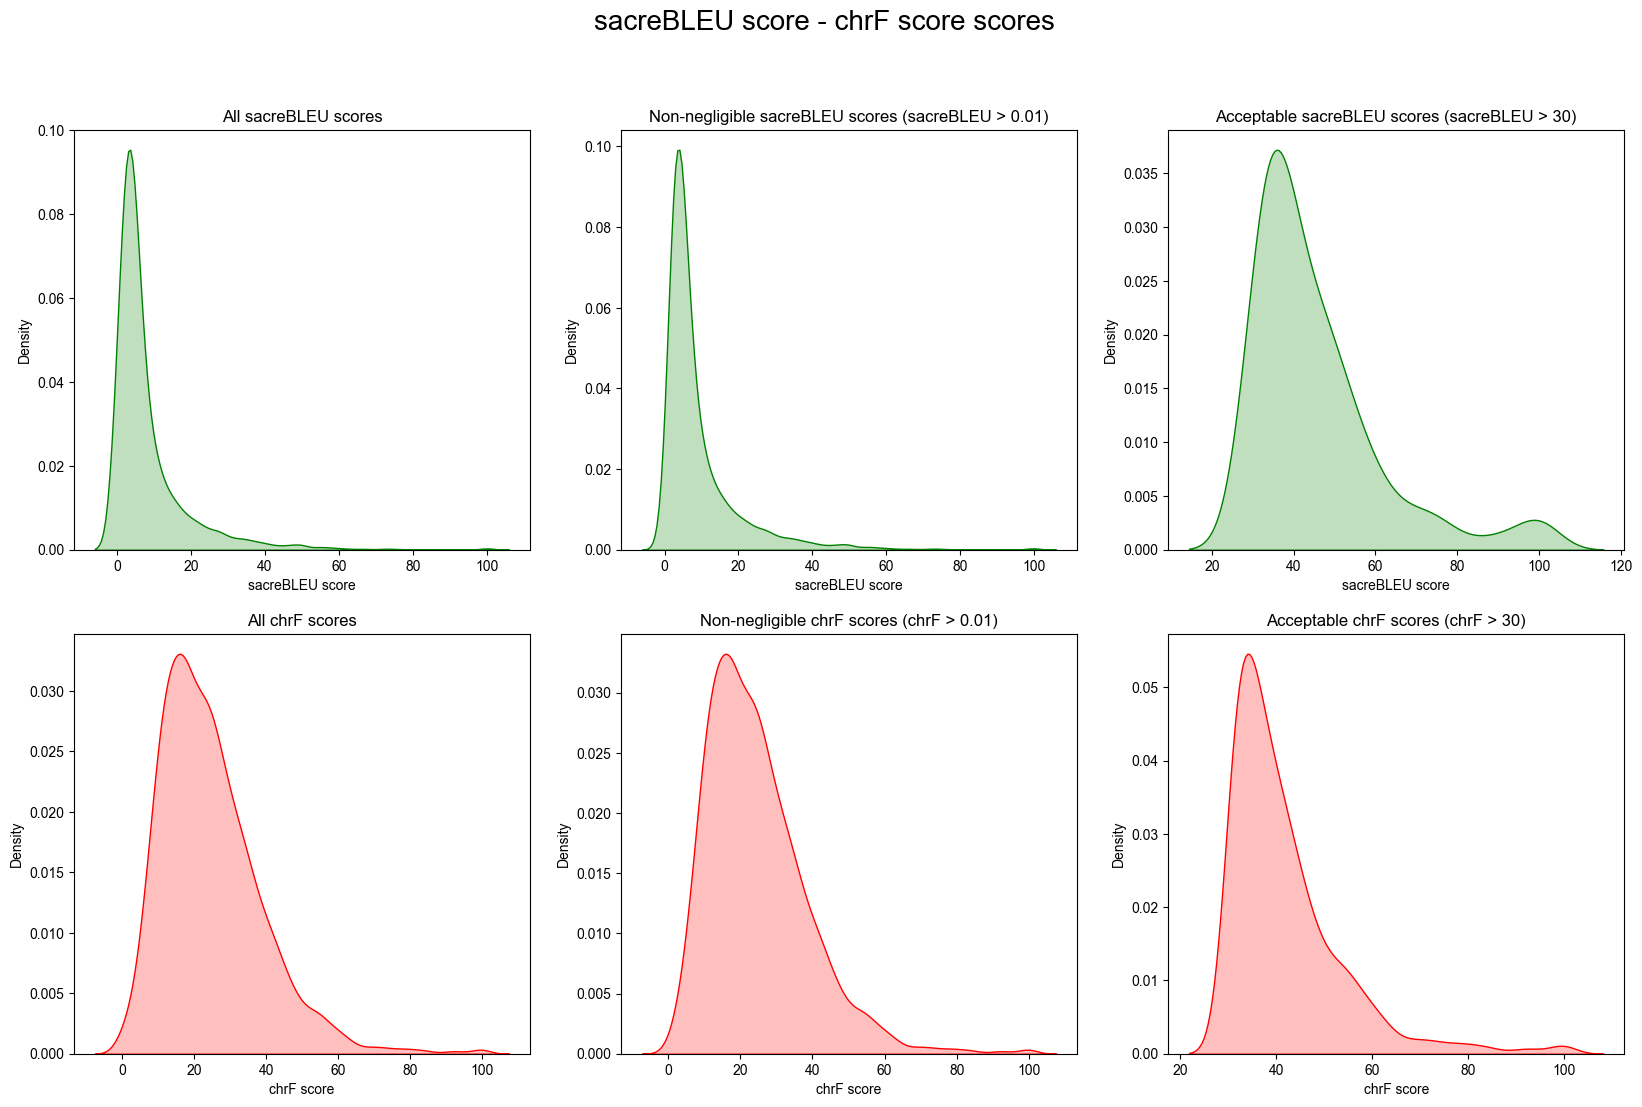

In [18]:
sacrebleu_scores    = bleu_scores_df[bleu_scores_df['metric'] == 'sacrebleu']['score']
chrf_scores         = bleu_scores_df[bleu_scores_df['metric'] == 'chrf']['score']
scores = [sacrebleu_scores, chrf_scores]

acceptance_thresholds = [30, 30]
epsilons = [0.01, 0.01]
save_path = os.path.join(CURRENT_RESULTS_FOLDER, 'bleu_scores.png')

sacrebleu_titles = ['All sacreBLEU scores', f'Non-negligible sacreBLEU scores (sacreBLEU > {epsilons[0]})', f'Acceptable sacreBLEU scores (sacreBLEU > {acceptance_thresholds[0]})']
chrf_titles = ['All chrF scores', f'Non-negligible chrF scores (chrF > {epsilons[1]})', f'Acceptable chrF scores (chrF > {acceptance_thresholds[1]})']
titles = [sacrebleu_titles, chrf_titles]
xlabels = ['sacreBLEU score', 'chrF score']
colors = ['green', 'red']

plot_thresholded_scores(scores, titles, xlabels, acceptance_thresholds, epsilons, save_path=save_path, colors=colors)

### **Best BLEU scores**

In [19]:
def get_ordered_score_indexes(scores, best=True, limit=3):
    return sorted(range(len(scores)), key=lambda i: scores[i], reverse=best)[:limit]

def show_translations(indexes, reference_source, reference_destination, decoded_outputs, save_path=None):

    printed_messages = []
    for idx in indexes:
        reference_destination_tokens = set(reference_destination[idx].strip().split(' '))
        decoded_output_tokens = set(decoded_outputs[idx].strip().split(' '))
        overlapping_words = reference_destination_tokens.intersection(decoded_output_tokens)
        
        printed_message = [
            f'Index: {idx}',
            f'Reference source: {reference_source[idx][:-1]}',
            f'Reference destination: {reference_destination[idx][:-1]}',
            f'Decoded output: {decoded_outputs[idx]}',
            f'Reference destination tokens: {reference_destination_tokens}',
            f'Decoded output tokens: {decoded_output_tokens}',
            f'Overlapping words: {overlapping_words}',
            '------------------'
        ]
        printed_messages.append('\n'.join(printed_message))

    for message in printed_messages:
        print(message)

    if save_path is not None:
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write('\n\n'.join(printed_messages))

In [20]:
best_indexes = get_ordered_score_indexes(list(sacrebleu_scores), best=True, limit=10)
save_dir = os.path.join(CURRENT_RESULTS_FOLDER, 'best_translations.txt')
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs, save_path=save_dir)

Index: 3774
Reference source: Mitâ he'i:
Reference destination: El niño dijo:
Decoded output: El niño dijo:

Reference destination tokens: {'El', 'niño', 'dijo:'}
Decoded output tokens: {'El', 'niño', 'dijo:'}
Overlapping words: {'El', 'niño', 'dijo:'}
------------------
Index: 3925
Reference source: Embotyꞌo
Reference destination: Abrir
Decoded output: Abrir

Reference destination tokens: {'Abrir'}
Decoded output tokens: {'Abrir'}
Overlapping words: {'Abrir'}
------------------
Index: 3943
Reference source: Arandukaporupyre
Reference destination: Bibliografía
Decoded output: Bibliografía

Reference destination tokens: {'Bibliografía'}
Decoded output tokens: {'Bibliografía'}
Overlapping words: {'Bibliografía'}
------------------
Index: 3960
Reference source: Ekopia taꞌãnga
Reference destination: Copiar imagen
Decoded output: Copiar imagen

Reference destination tokens: {'imagen', 'Copiar'}
Decoded output tokens: {'imagen', 'Copiar'}
Overlapping words: {'Copiar', 'imagen'}
-------------

In [21]:
best_indexes = get_ordered_score_indexes(list(chrf_scores), best=True, limit=10)
#save_dir = os.path.join(CURRENT_RESULTS_FOLDER, 'best_translations.txt')
show_translations(best_indexes, reference_source_gn, reference_destination_es, decoded_outputs, save_path=None)

Index: 548
Reference source: Péicha avei Juan Carlos Muñoz, presidente Centro de Armadores Fluviales y Maritimos del Paraguay, ombojoapy permiso poteî jasy buque osyryry jey haguã.
Reference destination: Por su parte, Juan Carlos Muñoz, presidente del Centro de Armadores Fluviales y Maritimos del Paraguay, añadió que el permiso es por seis meses, a fin de que el buque siga su curso.
Decoded output: Por su parte, Juan Carlos Muñoz, presidente del Centro de ArmadoresFluviales y Maritimos del Paraguay, añadió que el permiso es por seis meses, a fin de que el buque siga su curso.

Reference destination tokens: {'buque', 'siga', 'es', 'Carlos', 'de', 'Por', 'presidente', 'y', 'seis', 'que', 'Maritimos', 'parte,', 'del', 'Armadores', 'Muñoz,', 'Centro', 'el', 'su', 'añadió', 'fin', 'Fluviales', 'meses,', 'permiso', 'curso.', 'a', 'por', 'Juan', 'Paraguay,'}
Decoded output tokens: {'buque', 'siga', 'es', 'Carlos', 'de', 'Por', 'presidente', 'y', 'seis', 'que', 'Maritimos', 'parte,', 'del', 'M

In [22]:
worst_indexes = get_ordered_score_indexes(list(sacrebleu_scores), best=False)
show_translations(worst_indexes, reference_source_gn, reference_destination_es, decoded_outputs)

Index: 24
Reference source: Exitoso festival dÑoha'anga Ypakaraípe
Reference destination: Exitoso festival de teatro en Ypacaraí
Decoded output: Exrror al usuarios del colegio

Reference destination tokens: {'festival', 'de', 'Ypacaraí', 'teatro', 'en', 'Exitoso'}
Decoded output tokens: {'colegio', 'Exrror', 'al', 'del', 'usuarios'}
Overlapping words: set()
------------------
Index: 66
Reference source: ARP ojeúre pytyvõ urgente Transchaco gotyo
Reference destination: ARP pide arreglo urgente de la Transchaco
Decoded output: Lanzan antologíaes que modifican al Poder Ejecutivo en el CM

Reference destination tokens: {'ARP', 'pide', 'Transchaco', 'de', 'la', 'arreglo', 'urgente'}
Decoded output tokens: {'que', 'el', 'Ejecutivo', 'Lanzan', 'modifican', 'al', 'CM', 'en', 'antologíaes', 'Poder'}
Overlapping words: set()
------------------
Index: 70
Reference source: Especial Ovecha Rague-pe guarã
Reference destination: Especial para el Ovecha Rague
Decoded output: Repudian la tasa del pasaj

In [23]:
worst_indexes = get_ordered_score_indexes(list(chrf_scores), best=False)
show_translations(worst_indexes, reference_source_gn, reference_destination_es, decoded_outputs)

Index: 768
Reference source: Omýi yvate ha yvy gotyo hogapeguáicha FTC rope'a guýpe
Reference destination: SE MUEVE A SUS ANCHAS EN LAS NARICES DE LA FTC
Decoded output: que en la hora más importante, la falta de clases estaba bautizado con él

Reference destination tokens: {'NARICES', 'FTC', 'A', 'EN', 'LAS', 'LA', 'ANCHAS', 'MUEVE', 'SE', 'DE', 'SUS'}
Decoded output tokens: {'que', 'estaba', 'con', 'falta', 'de', 'más', 'la', 'hora', 'clases', 'importante,', 'bautizado', 'él', 'en'}
Overlapping words: set()
------------------
Index: 1048
Reference source: Makabra estrategia ohapejokóvo Extradición oîva hese
Reference destination: SERÍA MACABRA ESTRATEGIA PARA EVITAR SU EXTRADICIÓN
Decoded output: Fiesta de la tierra impiden medidas contra incendios.

Reference destination tokens: {'ESTRATEGIA', 'EVITAR', 'EXTRADICIÓN', 'SERÍA', 'PARA', 'MACABRA', 'SU'}
Decoded output tokens: {'medidas', 'de', 'la', 'tierra', 'contra', 'impiden', 'Fiesta', 'incendios.'}
Overlapping words: set()
------

### **¿What about the missing line?**

In [24]:
def plot_values_by_index(title, values, color=None):
    sns.set_style('darkgrid')
    x = list(range(len(values)))
    y = values
    plt.title(title)
    plt.plot(x, y, color=color)
    plt.show()

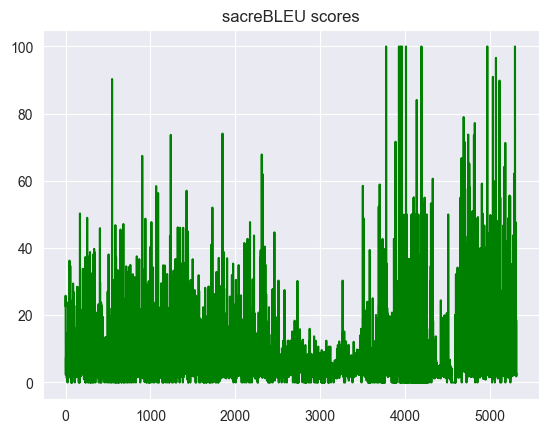

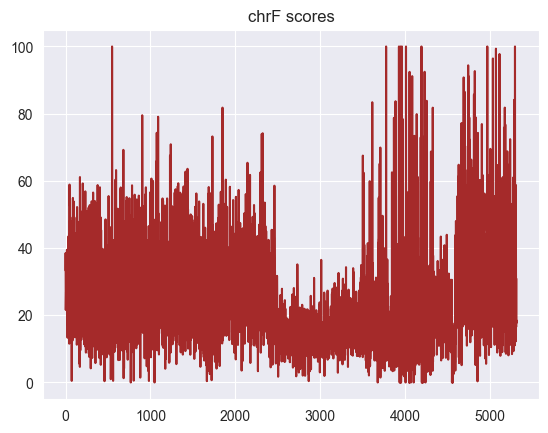

In [25]:
plot_values_by_index('sacreBLEU scores', sacrebleu_scores, color='green')
plot_values_by_index('chrF scores', chrf_scores, color='brown')